# Figures for chapter data

## A DEM of the Zwalm catchment

In [48]:
import openeo
import geopandas as gpd
import pandas as pd
import shapely
from pathlib import Path
import numpy as np
import pickle
import xarray as xr
import rioxarray
from rasterio import enums
import hvplot
import hvplot.xarray
import hvplot.pandas
import hvplot.dask
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import contextily as cx
from matplotlib import colors
from matplotlib.colors import LightSource
connection = openeo.connect("openeo.vito.be").authenticate_oidc()
pad = Path(os.getcwd())
if pad.name != "Python":
    pad_correct = Path("../../Python")
    os.chdir(pad_correct)
from functions.plotting_functions import plot_discrete_raster, plot_continuous_raster
exec_download = True
write_fig = True

%load_ext autoreload
%autoreload 2

Authenticated using refresh token.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#connection.list_collections()
connection.describe_collection('COPERNICUS_30')

{'assets': {'metadata_iso_19139': {'href': 'https://services.terrascope.be/collectioncatalogue/srv/api/records/urn:eop:VITO:COP_DEM_GLO_30M_COG/formatters/xml?approved=true',
   'roles': ['metadata', 'iso-19139'],
   'title': 'ISO 19139 metadata',
   'type': 'application/vnd.iso.19139+xml'},
  'thumbnail': {'href': 'https://services.terrascope.be/collectioncatalogue/images/quicklooks/COP_DEM_GLO_30M_COG_QL.png',
   'roles': ['thumbnail'],
   'title': 'Thumbnail',
   'type': 'image/png'}},
 'cube:dimensions': {'bands': {'type': 'bands', 'values': ['DEM']},
  't': {'extent': ['2010-12-12T00:00:00Z', None], 'type': 'temporal'},
  'x': {'axis': 'x',
   'extent': [-180, 180],
   'step': 0.0002777777777777778,
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [-90, 90],
   'step': 0.0002777777777777778,
   'type': 'spatial'}},
 'description': 'Copernicus Global 30 meter Digital Elevation Model dataset in COG format.',
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['2010-12-12T00:00:00Z', None]]}},
 'id': 'COPERNICUS_30',
 'keywords': ['VITO',
  'TERRASCOPE',
  'COPERNICUS',
  'ESA',
  'Radar',
  'TDX',
  'TSX',
  'Elevation',
  'DSM',
  'DEM'],
 'license': 'proprietary',
 'links': [{'href': 'https://spacedata.copernicus.eu/documents/20126/0/CSCDA_ESA_Mission-specific+Annex.pdf',
   'rel': 'license'},
  {'href': 'https://services.terrascope.be/wmts/v2',
   'rel': 'wmts',
   'wmts:layer': 'COP_DEM_GLO_30M_COG'}],
 'providers': [{'name': 'VITO, on behalf of the Belgian Science Policy Office (BELSPO).',
   'roles': ['producer', 'licensor'],
   'url': 'https://terrascope.be'}],
 'stac_extensions': ['datacube',
  'https://stac-extensions.github.io/eo/v1.0.0/schema.json'],
 'stac_version': '0.9.0',
 'summaries': {'eo:bands': [{'name': 'DEM'}],
  'instruments': ['TDX-1', 'TSX-1'],
  'platform': ['TSX', 'TDX']},
 'title': 'Copernicus Global 30 meter Digital Elevation Model dataset.'}

More info found here: https://portal.opentopography.org/datasetMetadata?otCollectionID=OT.032021.4326.1

In [3]:
collection = 'COPERNICUS_30'
shape_zwalm = gpd.read_file('data/Zwalm_shape/zwalm_shapefile_emma.shp')
extent = shape_zwalm.total_bounds
print(extent)

[ 3.66751526 50.76325563  3.83821038 50.90341411]


In [4]:
spatial_extent = {'west':extent[0],'east':extent[2],'south':extent[1],'north':extent[3]}
DEM = connection.load_collection(
    collection_id= collection,
    spatial_extent= spatial_extent
)
DEM = DEM.mask_polygon(shape_zwalm['geometry'].values[0])
if not os.path.exists('data/Zwalm_DEM'):
    os.makedirs('data/Zwalm_DEM')
if exec_download:
    DEM.download('data/Zwalm_DEM/DEM_Copernicus_30.nc',format = 'NetCDF')

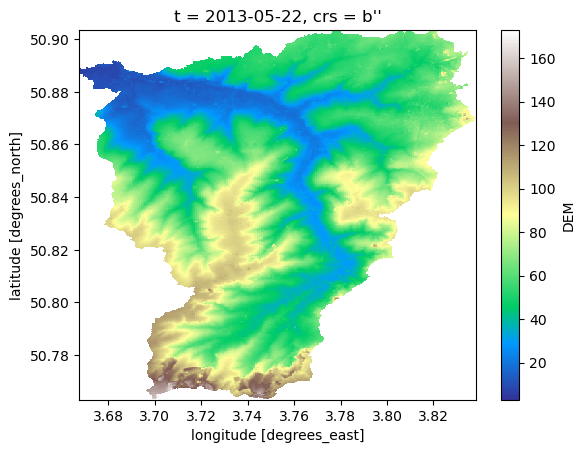

In [5]:
dem = xr.open_dataset('data/Zwalm_DEM/DEM_Copernicus_30.nc', decode_coords='all')
dem['DEM'].plot(cmap = 'terrain')

In [6]:
dem.rio.crs


CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]')

Text(0, 0.5, 'y [m]')

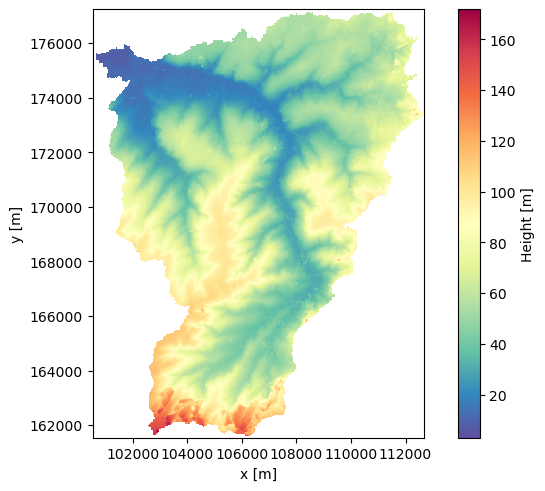

In [7]:
dem_31370 = dem.rio.reproject(dst_crs='EPSG:31370', resampling = enums.Resampling.bilinear)
fig, ax = plt.subplots(constrained_layout = True)
dem_31370['DEM'].plot(ax = ax, cmap = 'Spectral_r', cbar_kwargs = {'label':'Height [m]'})
ax.set_title('')
ax.set_aspect('equal','box')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

### Include Zwalm river on DEM

In [8]:
shape_zwalm_31370 = gpd.read_file('data/Zwalm_shape/zwalm_shapefile_emma_31370.shp')
VHA = gpd.read_file('data/VHA_waterlopen_20210204_GewVLA_Shapefile/Shapefile/Vhag.shp')

In [9]:
VHA_zwalm= VHA[VHA['NAAM'] == 'Zwalmbeek']
VHA_zwalm

OIDN   UIDN   VHAG       NAAM                     NAMEN    LENGTE  \
1446    3708   3708   5001  Zwalmbeek                 Zwalmbeek    348.61   
21102   5084  39578   5779  Zwalmbeek                 Zwalmbeek   1353.75   
21610  17215  40193  17516  Zwalmbeek                 Zwalmbeek    135.78   
26398   3707  45714   5000  Zwalmbeek  Zwalmbeek - Dorenbosbeek  22474.02   

                                                geometry  
1446   LINESTRING (104155.250 174948.953, 104147.271 ...  
21102  LINESTRING (101513.086 175367.418, 101514.771 ...  
21610  LINESTRING (105901.209 174494.337, 105899.842 ...  
26398  LINESTRING (105430.433 162448.406, 105433.026 ...

In [10]:
VHA = VHA.set_crs(epsg=31370, allow_override=True)
VHA.crs

<Derived Projected CRS: EPSG:31370>
Name: BD72 / Belgian Lambert 72
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Belgium - onshore.
- bounds: (2.5, 49.5, 6.4, 51.51)
Coordinate Operation:
- name: Belgian Lambert 72
- method: Lambert Conic Conformal (2SP)
Datum: Reseau National Belge 1972
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

In [11]:
shape_zwalm_31370.crs

<Derived Projected CRS: EPSG:31370>
Name: BD72 / Belgian Lambert 72
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Belgium - onshore.
- bounds: (2.5, 49.5, 6.4, 51.51)
Coordinate Operation:
- name: Belgian Lambert 72
- method: Lambert Conic Conformal (2SP)
Datum: Reseau National Belge 1972
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

<Axes: >

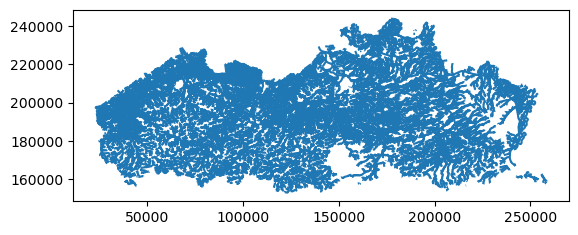

In [12]:
VHA.plot()

In [13]:
shape_zwalm_31370['geometry']

0    POLYGON ((107820.000 164940.000, 107830.000 16...
Name: geometry, dtype: geometry

In [14]:
extent_31370 = shape_zwalm_31370.total_bounds
extent_31370

array([100660.    , 161605.0002, 112655.    , 177150.0002])

In [15]:
VHA_zwalm_all = VHA[VHA['geometry'].within(shape_zwalm_31370['geometry'].values[0])]
#important to supply a raw geometry

In [16]:
VHA_zwalm = pd.concat([VHA_zwalm, VHA_zwalm_all])

<Axes: >

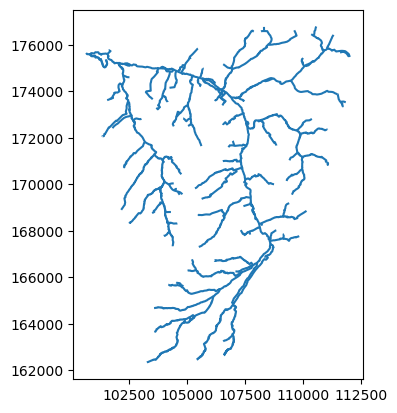

In [17]:
VHA_zwalm.plot()

In [18]:
dem_31370['DEM'].values[0].shape

(634, 491)

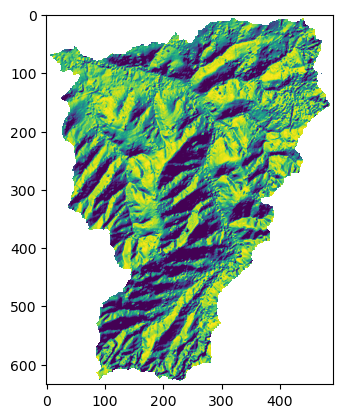

In [19]:
ls = LightSource(azdeg=315, altdeg=45)
plt.imshow(ls.hillshade(dem_31370['DEM'].values[0]))

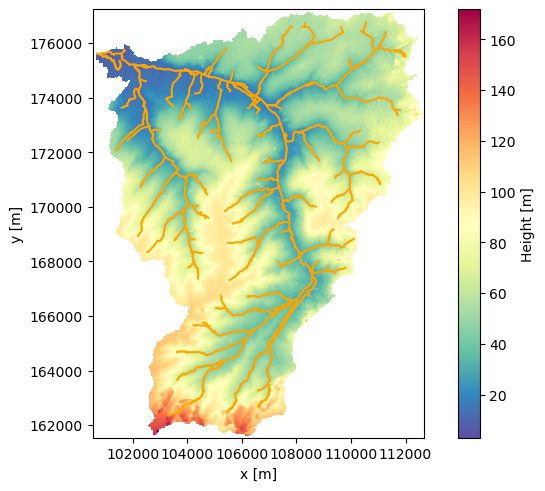

In [20]:
fig, ax = plt.subplots(constrained_layout = True)
dem_31370['DEM'].plot(ax = ax, cmap = 'Spectral_r', cbar_kwargs = {'label':'Height [m]'})
#ls = LightSource(azdeg=315, altdeg=45)
#ax.imshow(ls.hillshade(dem_31370['DEM'].values[0]),cmap = 'Spectral_r')#, cbar_kwargs = {'label':'Height [m]'})
VHA_zwalm.plot(ax = ax, color = 'orange')
ax.set_title('')
ax.set_aspect('equal','box')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
#cx.add_basemap(ax, crs = VHA_zwalm.crs, source = cx.providers.OpenStreetMap.Mapnik)
if not os.path.exists('Figures/Figures_chapter_data'):
    os.makedirs('Figures/Figures_chapter_data')
if write_fig:
    fig.savefig('Figures/Figures_chapter_data/DEM_zwalm.png', format = 'png')
    fig.savefig('Figures/Figures_chapter_data/DEM_zwalm.pdf', format = 'pdf')

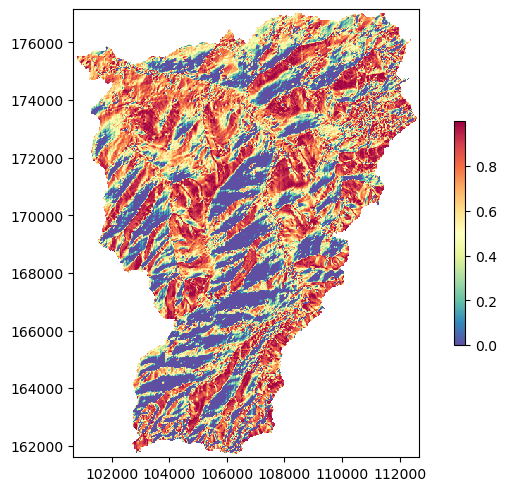

In [21]:
fig, ax = plt.subplots(constrained_layout = True)
fig, ax = plot_continuous_raster(
    fig, ax,dem_31370['DEM'].values[0],
    bounds = extent_31370,
    cmap = 'Spectral_r',
    hillshade=True,
    colorbar=True  
)

## Forcing data

### Rainfall

In [68]:
# p_info = pd.read_pickle('data/Zwalm_data/pywaterinfo_output/P_info_dict.pickle')
# display(p_info)
# p_info['Elst']

In [69]:
p_info = pd.read_pickle('data/Zwalm_data/preprocess_output/gdf_P_info.pkl')
hvplot.extension('bokeh')
p_info.hvplot(geo = True, crs = 31370, tiles = 'OSM')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]

https://scitools.org.uk/cartopy/docs/v0.15/examples/tube_stations.html

In [70]:
# import cartopy.io.img_tiles as cimgt
# request = cimgt.OSM()
# #ax = plt.axes(projection = ccrs.epsg(31370))
# ax = plt.axes(projection = request.crs)
# #p_info.plot(ax = ax)
# ax.add_image(request, 8)
# plt.show()

Text(0.5, 1.0, 'Rainfall gauges')

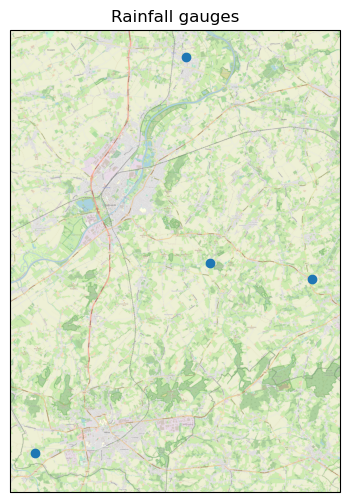

In [71]:
from cartopy.io.img_tiles import OSM
imagery = OSM()
fig = plt.figure(figsize = (14,6))
ax = plt.axes(projection = imagery.crs)
ax.add_image(imagery, 14)
p_info.plot(ax = ax, transform = ccrs.epsg(31370))
ax.set_title('Rainfall gauges')

https://geopandas.org/en/stable/gallery/plotting_basemap_background.html Zal stuk makkelijker zijn dan via cartopy zelf! 

https://contextily.readthedocs.io/en/latest/

In [72]:
p_info

station_no     station_name   station_latitude  station_longitude  \
0  plu06a-1066       Elst OTT_P   50.8123721075798    3.7385409127989   
1      P06_014  Maarke-Kerkem_P  50.81897472066046  3.670943420513861   
2      P06_040         Zingem_P  50.90566742609524  3.655040221398179   
3  plu12a-1066      Ronse OTT_P   50.7390614687472   3.55392527166326   

  station_local_x station_local_y station_georefsystem     ts_id ts_unitname  \
0        105585.0        167069.0   Belgian Lambert 72  13827010  millimeter   
1        100828.0        167846.0     Belge Lambert 72  35024042  millimeter   
2         99800.0        177500.0     Belge Lambert 72  35032042  millimeter   
3         92485.0        159041.0   Belgian Lambert 72  14040010  millimeter   

                        geometry           name  
0  POINT (105585.000 167069.000)           Elst  
1  POINT (100828.000 167846.000)  Maarke-Kerkem  
2   POINT (99800.000 177500.000)         Zingem  
3   POINT (92485.000 159041.000)          Ronse

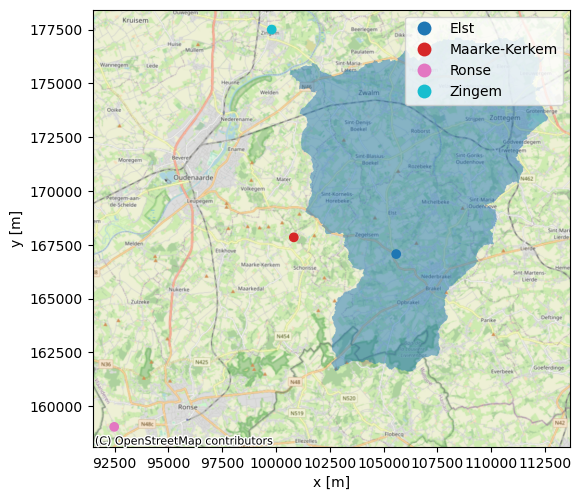

In [73]:
fig, ax = plt.subplots(figsize = (5.7,5.5), constrained_layout = True)#figsize = (16,8))
p_info.plot(ax = ax,column = 'name',categorical = True, legend = True)
shape_zwalm_31370.plot(ax = ax, alpha = 0.5)
cx.add_basemap(ax, crs = p_info.crs, source = cx.providers.OpenStreetMap.Mapnik)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
if write_fig:
    fig.savefig('Figures/Figures_chapter_data/rain_gauges.pdf', format = 'pdf')
#ax.set_title('Rain gauges')

11


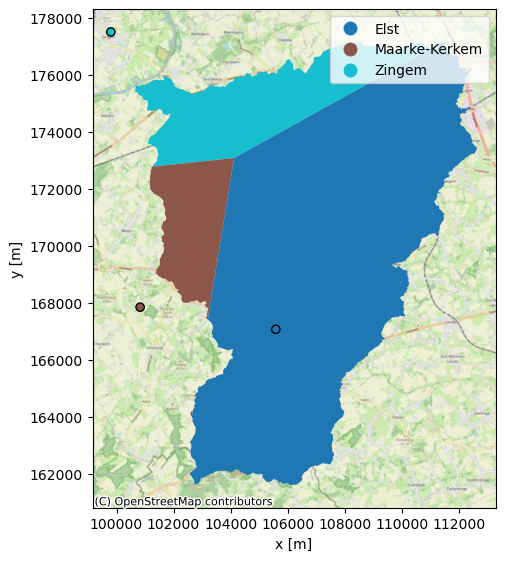

In [74]:
all_p_polygons = pickle.load(open('data/Zwalm_data/preprocess_output/all_p_polygon_combinations.pkl', "rb"))
length = len(all_p_polygons)
print(length)
fig, ax = plt.subplots(figsize = (5.5,5.5), constrained_layout = True)
all_p_polygons[length-1].plot(ax = ax, column = 'name', categorical = True)
p_info[0:-1].plot(ax = ax,column = 'name',categorical = True, legend = True, edgecolor = 'k')
cx.add_basemap(ax, crs = p_info.crs, source = cx.providers.OpenStreetMap.Mapnik)
ax.set_aspect('equal','box')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
if write_fig:
    fig.savefig('Figures/Figures_chapter_data/rain_thiessen_polygons.pdf', format = 'pdf')
#ax.set_titel('Thiessen Polygons

Attempt at combining the 2 above plots in one

In [75]:
# fig, ax = plt.subplots(figsize = (5.5,5.5), constrained_layout = True)
# all_p_polygons[length-1].plot(ax = ax, column = 'name', categorical = True)
# p_info.plot(ax = ax,column = 'name',categorical = True, edgecolor = 'k', legend = True)
# #p_info.iloc[-1:].plot(ax = ax,categorical = True, edgecolor = 'k', color = 'red')
# cx.add_basemap(ax, crs = p_info.crs, source = cx.providers.OpenStreetMap.Mapnik)
# #ax.legend([p_info['name'].to_list()[0:3],p_info['name'].to_list()[-1]])
# ax.set_aspect('equal','box')
# ax.set_xlabel('x [m]')
# ax.set_ylabel('y [m]')

https://matplotlib.org/stable/tutorials/colors/colors.html

In [76]:
# fig, ax = plt.subplots(figsize = (5.5,5.5), constrained_layout = True)
# polygons_sorted = all_p_polygons[length-1].sort_values('name')
# p_info_sorted = p_info.sort_index()
# # polygons_sorted.plot(ax = ax, categorical = True, column = 'name')
# # p_info_sorted.plot(ax = ax, categorical = True, column = 'name')
# polygons_sorted.plot(ax = ax, color = ['red','green','blue'])
# p_info_sorted.plot(ax = ax, color = ['red','green','blue','purple'], edgecolor = 'k', legend = True)
# ax.legend()
# cx.add_basemap(ax, crs = p_info.crs, source = cx.providers.OpenStreetMap.Mapnik)
# #ax.legend([p_info['name'].to_list()[0:3],p_info['name'].to_list()[-1]])
# ax.set_aspect('equal','box')
# ax.set_xlabel('x [m]')
# ax.set_ylabel('y [m]')

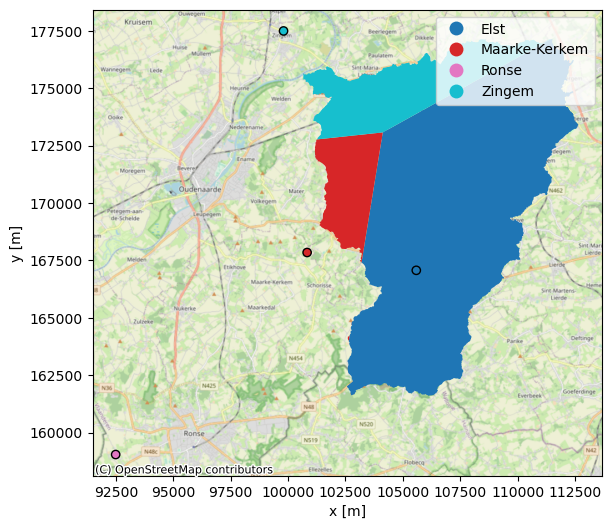

In [77]:
polygons_sorted = all_p_polygons[length-1].sort_values('name')
p_info_sorted = p_info.sort_index()
fig, ax = plt.subplots(figsize = (6,5.5), constrained_layout = True)
polygons_sorted.plot(ax = ax, color = ['#1f76b5','#d72628','#17bfce'])
p_info_sorted.plot(ax = ax,column = 'name',categorical = True, edgecolor = 'k', legend = True)
#p_info.iloc[-1:].plot(ax = ax,categorical = True, edgecolor = 'k', color = 'red')
cx.add_basemap(ax, crs = p_info.crs, source = cx.providers.OpenStreetMap.Mapnik)
#ax.legend([p_info['name'].to_list()[0:3],p_info['name'].to_list()[-1]])
ax.set_aspect('equal','box')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
fig
if write_fig:
    plt.savefig('Figures/Figures_chapter_data/rain_combined.pdf',format = 'pdf')

TO DO: sorteer op manier zodat Elst, Maarke-Kerkem en Zingem eerst met DAN ronse er na! enkel op die manier kan zelfde kleur worden gegarandeerd! 

In [78]:
polygons_sorted

station_name           name                       location  \
2       Elst OTT_P           Elst  POINT (105585.000 167069.000)   
1  Maarke-Kerkem_P  Maarke-Kerkem  POINT (100828.000 167846.000)   
0         Zingem_P         Zingem   POINT (99800.000 177500.000)   

                                            geometry          Area  \
2  POLYGON ((102682.593 164250.000, 102685.000 16...  8.589533e+07   
1  MULTIPOLYGON (((104124.669 173078.777, 103200....  1.038313e+07   
0  MULTIPOLYGON (((111155.000 176977.776, 111155....  1.893016e+07   

   relative_area  
2       0.745563  
1       0.090125  
0       0.164312

In [79]:
p_info_sorted

station_no     station_name   station_latitude  station_longitude  \
0  plu06a-1066       Elst OTT_P   50.8123721075798    3.7385409127989   
1      P06_014  Maarke-Kerkem_P  50.81897472066046  3.670943420513861   
2      P06_040         Zingem_P  50.90566742609524  3.655040221398179   
3  plu12a-1066      Ronse OTT_P   50.7390614687472   3.55392527166326   

  station_local_x station_local_y station_georefsystem     ts_id ts_unitname  \
0        105585.0        167069.0   Belgian Lambert 72  13827010  millimeter   
1        100828.0        167846.0     Belge Lambert 72  35024042  millimeter   
2         99800.0        177500.0     Belge Lambert 72  35032042  millimeter   
3         92485.0        159041.0   Belgian Lambert 72  14040010  millimeter   

                        geometry           name  
0  POINT (105585.000 167069.000)           Elst  
1  POINT (100828.000 167846.000)  Maarke-Kerkem  
2   POINT (99800.000 177500.000)         Zingem  
3   POINT (92485.000 159041.000)          Ronse

In [80]:
# fig, ax = plt.subplots(figsize = (7,7))
# all_p_polygons[length-4].plot(ax = ax, column = 'name', categorical = True)
# p_info[0:-1].plot(ax = ax,column = 'name',categorical = True, legend = True, edgecolor = 'k')
# cx.add_basemap(ax, crs = p_info.crs, source = cx.providers.OpenStreetMap.Mapnik)
# ax.set_aspect('equal','box')
# ax.set_xlabel('x [m]')
# ax.set_ylabel('y [m]')

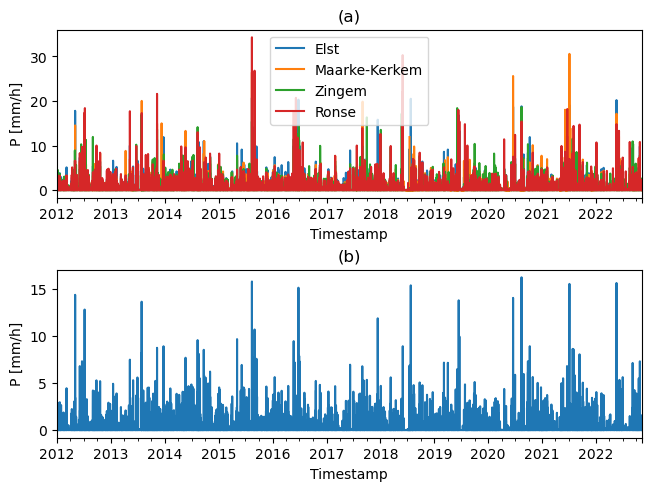

In [81]:
p_thiessen = pd.read_pickle('data/Zwalm_data/preprocess_output/zwalm_p_thiessen.pkl')
p_thiessen = p_thiessen.set_index('Timestamp')
p_thiessen = p_thiessen.drop('#_nonan_stations', axis = 'columns')
fig, axes = plt.subplots(2,1, constrained_layout = True)
p_thiessen.drop('P_thiessen', axis = 'columns').plot(ax =axes[0])
axes[0].set_ylabel('P [mm/h]')
axes[0].set_title('(a)')
p_thiessen['P_thiessen'].plot(ax = axes[1])
axes[1].set_ylabel('P [mm/h]')
axes[1].set_title('(b)')
if write_fig:
    fig.savefig('Figures/Figures_chapter_data/rain_timeseries.pdf', format = 'pdf')

### Evapotranspiration

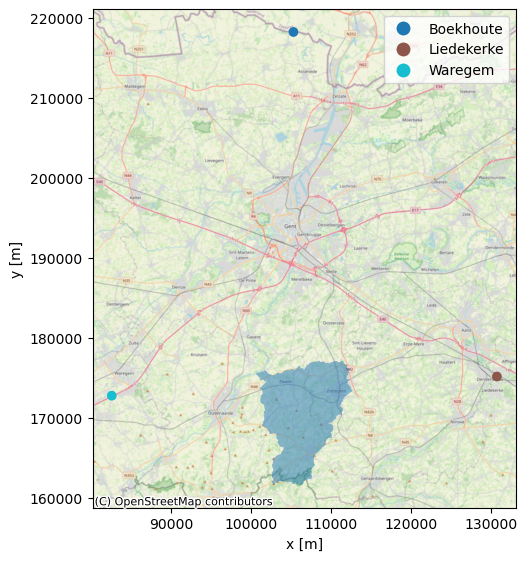

In [64]:
ep_info = pd.read_pickle('data/Zwalm_data/preprocess_output/gdf_EP_info.pkl')
fig, ax = plt.subplots(figsize = (5.5,5.5), constrained_layout = True)
ep_info.plot(ax = ax,column = 'name',categorical = True, legend = True)
shape_zwalm_31370.plot(ax = ax, alpha = 0.5)
cx.add_basemap(ax, crs = p_info.crs, source = cx.providers.OpenStreetMap.Mapnik)
ax.set_aspect('equal','box')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
if write_fig:
    fig.savefig('Figures/Figures_chapter_data/meteorological_stations.pdf', format = 'pdf')

4


station_name        name                       location  \
0     Waregem_ME     Waregem   POINT (82595.000 172779.000)   
1  Liedekerke_ME  Liedekerke  POINT (130730.000 175177.000)   

                                            geometry          Area  \
0  POLYGON ((107240.790 162370.000, 107240.000 16...  6.584572e+07   
1  POLYGON ((106556.288 176110.000, 106560.000 17...  4.936290e+07   

   relative_area  
0       0.571535  
1       0.428465

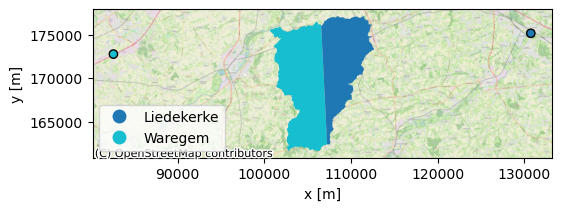

In [65]:
all_ep_polygons = pickle.load(open('data/Zwalm_data/preprocess_output/all_ep_polygon_combinations.pkl', "rb"))
length = len(all_ep_polygons)
print(length)
fig, ax = plt.subplots(figsize = (5.5,2.5), constrained_layout = True)
display(all_ep_polygons[length-1])
all_ep_polygons[length-1].plot(ax = ax, column = 'name', categorical = True)
ep_info[0:-1].plot(ax = ax,column = 'name',categorical = True, legend = True, edgecolor = 'k')
cx.add_basemap(ax, crs = ep_info.crs, source = cx.providers.OpenStreetMap.Mapnik)
ax.set_aspect('equal','box')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
if write_fig:
    fig.savefig('Figures/Figures_chapter_data/et_thiessen_polygons.pdf', format = 'pdf')

Again attempting to combine the 2 above plots!

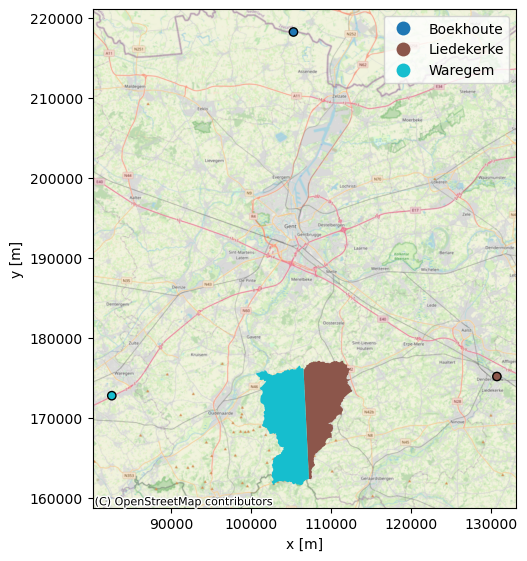

In [66]:
polygons_sorted = all_ep_polygons[length-1].sort_values('name')
ep_info_sorted = ep_info.sort_index()
fig, ax = plt.subplots(figsize = (5.5,5.5), constrained_layout = True)
polygons_sorted.plot(ax = ax, color = ['#8c564b','#16bece'])
ep_info_sorted.plot(ax = ax,column = 'name',categorical = True, edgecolor = 'k', legend = True)
#p_info.iloc[-1:].plot(ax = ax,categorical = True, edgecolor = 'k', color = 'red')
cx.add_basemap(ax, crs = p_info.crs, source = cx.providers.OpenStreetMap.Mapnik)
#ax.legend([p_info['name'].to_list()[0:3],p_info['name'].to_list()[-1]])
ax.set_aspect('equal','box')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
if write_fig:
    plt.savefig('Figures/Figures_chapter_data/et_combined.pdf',format = 'pdf')

In [43]:
display(polygons_sorted)
display(ep_info_sorted)

station_name        name                       location  \
1  Liedekerke_ME  Liedekerke  POINT (130730.000 175177.000)   
0     Waregem_ME     Waregem   POINT (82595.000 172779.000)   

                                            geometry          Area  \
1  POLYGON ((106556.288 176110.000, 106560.000 17...  4.936290e+07   
0  POLYGON ((107240.790 162370.000, 107240.000 16...  6.584572e+07   

   relative_area  
1       0.428465  
0       0.571535

station_no   station_name   station_latitude  station_longitude  \
0   ME07_006  Liedekerke_ME  50.88663187754852  4.094898384426233   
1   ME05_019     Waregem_ME  50.86149201352459  3.411318491131938   
2   ME03_017   Boekhoute_ME  51.27226222700116  3.728298780917451   

  station_local_x station_local_y station_georefsystem     ts_id ts_unitname  \
0        130730.0        175177.0     Belge Lambert 72  94502042  millimeter   
1         82595.0        172779.0     Belge Lambert 72  94488042  millimeter   
2        105304.0        218235.0     Belge Lambert 72  94460042  millimeter   

                        geometry        name  
0  POINT (130730.000 175177.000)  Liedekerke  
1   POINT (82595.000 172779.000)     Waregem  
2  POINT (105304.000 218235.000)   Boekhoute

In [ ]:
# fig, ax = plt.subplots(figsize = (6.4,6.4), constrained_layout = True)
# all_ep_polygons[length-2].plot(ax = ax, column = 'name', categorical = True)
# ep_info.plot(ax = ax,column = 'name',categorical = True, legend = True, edgecolor = 'k')
# cx.add_basemap(ax, crs = ep_info.crs, source = cx.providers.OpenStreetMap.Mapnik)
# ax.set_aspect('equal','box')
# ax.set_xlabel('x [m]')
# ax.set_ylabel('y [m]')

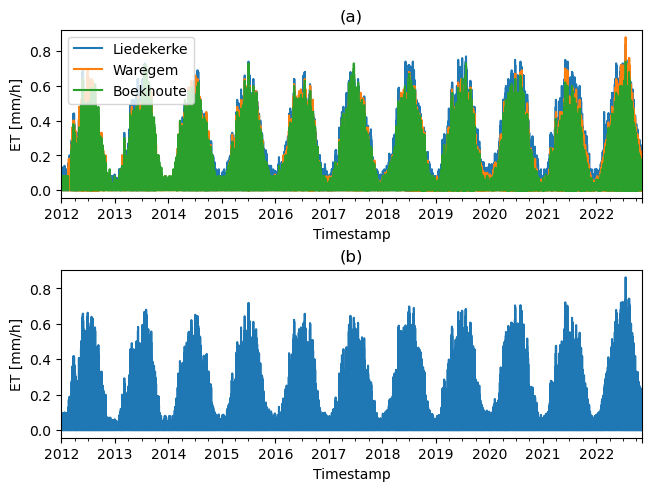

In [90]:
ep_thiessen = pd.read_pickle('data/Zwalm_data/preprocess_output/zwalm_ep_thiessen.pkl')
ep_thiessen = ep_thiessen.set_index('Timestamp')
ep_thiessen = ep_thiessen.drop('#_nonan_stations', axis = 'columns')
fig, axes = plt.subplots(2,1, constrained_layout = True)
ep_thiessen.drop(['EP_thiessen','EP_thiessen_ave_yearly'], axis = 'columns').plot(ax =axes[0])
axes[0].set_ylabel('ET [mm/h]')
axes[0].set_title('(a)')
ep_thiessen['EP_thiessen'].plot(ax = axes[1])
axes[1].set_ylabel('ET [mm/h]')
axes[1].set_title('(b)')
if write_fig:
    fig.savefig('Figures/Figures_chapter_data/et_timeseries.pdf', format = 'pdf')

In [91]:
ep_thiessen.head()

Liedekerke  Waregem  Boekhoute  \
Timestamp                                             
2012-01-01 00:00:00         0.0      0.0        0.0   
2012-01-01 01:00:00         0.0      0.0        0.0   
2012-01-01 02:00:00         0.0      0.0        0.0   
2012-01-01 03:00:00         0.0      0.0        0.0   
2012-01-01 04:00:00         0.0      0.0        0.0   

                                   nonan_station_sets gdf_index  Thiessen_Nan  \
Timestamp                                                                       
2012-01-01 00:00:00  {Liedekerke, Boekhoute, Waregem}         3         False   
2012-01-01 01:00:00  {Liedekerke, Boekhoute, Waregem}         3         False   
2012-01-01 02:00:00  {Liedekerke, Boekhoute, Waregem}         3         False   
2012-01-01 03:00:00  {Liedekerke, Boekhoute, Waregem}         3         False   
2012-01-01 04:00:00  {Liedekerke, Boekhoute, Waregem}         3         False   

                     EP_thiessen_ave_yearly  EP_thiessen  
Timestamp                                                 
2012-01-01 00:00:00                0.000857          0.0  
2012-01-01 01:00:00                0.003000          0.0  
2012-01-01 02:00:00                0.000428          0.0  
2012-01-01 03:00:00                0.000000          0.0  
2012-01-01 04:00:00                0.000000          0.0

## Flow Data

In [87]:
Q_hour = pd.read_pickle('data/Zwalm_data/pywaterinfo_output/Q_hour.pkl')
Q_day = pd.read_pickle('data/Zwalm_data/pywaterinfo_output/Q_day.pkl')
Q_day = Q_day.set_index('Timestamp')
display(Q_hour.head())
display(Q_day.head())

Timestamp  Value  Interpolation Type  Quality Code  \
0 2012-01-01 00:00:00  1.140               103.0         110.0   
1 2012-01-01 01:00:00  1.090               103.0          30.0   
2 2012-01-01 02:00:00  1.050               103.0          30.0   
3 2012-01-01 03:00:00  1.040               103.0          30.0   
4 2012-01-01 04:00:00  0.998               103.0          30.0   

  Quality Code Name                           Quality Code Description  \
0        ExcellentA  Excellent quality: based on automatic validati...   
1             GoodM     Good quality: based on manual validation  - 30   
2             GoodM     Good quality: based on manual validation  - 30   
3             GoodM     Good quality: based on manual validation  - 30   
4             GoodM     Good quality: based on manual validation  - 30   

         Quality Code Color Aggregation Accuracy % Absolute Value  \
0  rgba(170, 255, 170, 1.0)                   None           None   
1    rgba(47, 191, 43, 1.0)                   None           None   
2    rgba(47, 191, 43, 1.0)                   None           None   
3    rgba(47, 191, 43, 1.0)                   None           None   
4    rgba(47, 191, 43, 1.0)                   None           None   

  AV Interpolation Type  ... ReturnPeriod Occurrance Timestamp  \
0                  None  ...         None                 None   
1                  None  ...         None                 None   
2                  None  ...         None                 None   
3                  None  ...         None                 None   
4                  None  ...         None                 None   

  Occurrance Count Timeseries Comment Agent Comment Station Comment  \
0             None               None          None            None   
1             None               None          None            None   
2             None               None          None            None   
3             None               None          None            None   
4             None               None          None            None   

  Parameter Comment Data Comment Release State     ts_id  
0              None         None          None  68052042  
1              None         None          None  68052042  
2              None         None          None  68052042  
3              None         None          None  68052042  
4              None         None          None  68052042  

[5 rows x 29 columns]

Value  Interpolation Type  Quality Code Quality Code Name  \
Timestamp                                                               
2012-01-01   1.18                 603           110        ExcellentA   
2012-01-02   3.38                 603            30             GoodM   
2012-01-03   2.95                 603            30             GoodM   
2012-01-04   2.17                 603            30             GoodM   
2012-01-05   7.00                 603            30             GoodM   

                                     Quality Code Description  \
Timestamp                                                       
2012-01-01  Excellent quality: based on automatic validati...   
2012-01-02     Good quality: based on manual validation  - 30   
2012-01-03     Good quality: based on manual validation  - 30   
2012-01-04     Good quality: based on manual validation  - 30   
2012-01-05     Good quality: based on manual validation  - 30   

                  Quality Code Color  Aggregation Accuracy % Absolute Value  \
Timestamp                                                                     
2012-01-01  rgba(170, 255, 170, 1.0)                   100.0           None   
2012-01-02    rgba(47, 191, 43, 1.0)                   100.0           None   
2012-01-03    rgba(47, 191, 43, 1.0)                   100.0           None   
2012-01-04    rgba(47, 191, 43, 1.0)                   100.0           None   
2012-01-05    rgba(47, 191, 43, 1.0)                   100.0           None   

           AV Interpolation Type AV Quality Code  ... ReturnPeriod  \
Timestamp                                         ...                
2012-01-01                  None            None  ...         None   
2012-01-02                  None            None  ...         None   
2012-01-03                  None            None  ...         None   
2012-01-04                  None            None  ...         None   
2012-01-05                  None            None  ...         None   

           Occurrance Timestamp Occurrance Count Timeseries Comment  \
Timestamp                                                             
2012-01-01                 None             None               None   
2012-01-02                 None             None               None   
2012-01-03                 None             None               None   
2012-01-04                 None             None               None   
2012-01-05                 None             None               None   

           Agent Comment Station Comment Parameter Comment Data Comment  \
Timestamp                                                                 
2012-01-01          None            None              None         None   
2012-01-02          None            None              None         None   
2012-01-03          None            None              None         None   
2012-01-04          None            None              None         None   
2012-01-05          None            None              None         None   

           Release State     ts_id  
Timestamp                           
2012-01-01          None  68033042  
2012-01-02          None  68033042  
2012-01-03          None  68033042  
2012-01-04          None  68033042  
2012-01-05          None  68033042  

[5 rows x 28 columns]

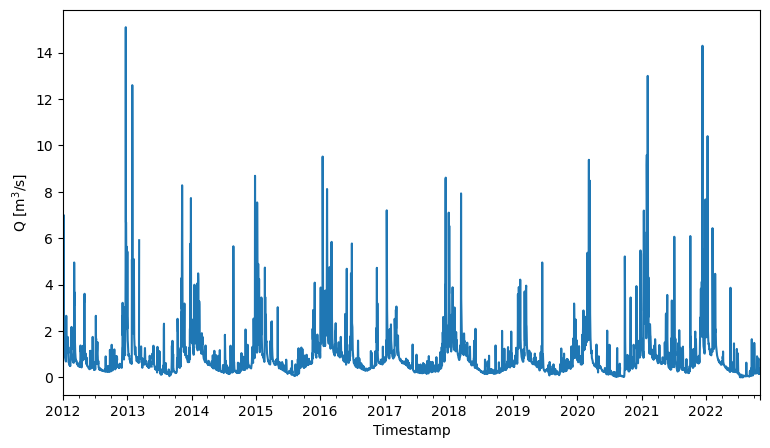

In [100]:
fig, ax = plt.subplots(figsize = (9,5))
Q_day['Value'].plot(ax = ax)
ax.set_ylabel(r'Q [m$^3$/s]')
if write_fig:
    plt.savefig('Figures/Figures_chapter_data/Q_daily.pdf',format = 'pdf')

## Landuse data

In [ ]:
landuse = rioxarray.open_rasterio('data/Zwalm_bodembedekking/wetransfer_landgebruik_2022-11-07_0921/'+
    'Landuse_Vlaanderen_Wallonie_final.sdat')
landuse = landuse.chunk('auto')#type:ignore
landuse_nonan = landuse.where(landuse != 255)

In [ ]:
landuse_nonan

In [ ]:
#landuse_nonan.isel(band = 0).hvplot(rasterize = True)

In [ ]:
landuse_zwalm = landuse_nonan.rio.clip(shape_zwalm_31370['geometry'].values,shape_zwalm_31370.crs)

In [ ]:
landuse_zwalm = landuse_zwalm.isel(band = 0).where(landuse_zwalm.isel(band = 0) != 255)
#landuse_zwalm

In [ ]:
np.sum(~np.isnan(landuse_zwalm.values))
landuse_zwalm

In [ ]:
#Taken from Fluves
colormap = colors.ListedColormap(
            [
                "#000000",
                "#387b00",
                "#64cf1b",
                 "#a47158",
                "#00bfff",
            ]
        )
labels = [
    'Urban',
    'Forest',
    'Pasture',
    'Agriculture',
    'Water'
]


In [ ]:
fig, ax = plt.subplots(constrained_layout = True)
fig, ax = plot_discrete_raster(fig, ax, landuse_zwalm.values, bounds = extent_31370, labels = labels, cmap = colormap)
ax.set_aspect('equal','box')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
if write_fig:
    fig.savefig('Figures/Figures_chapter_data/Landuse_zwalm.png', format = 'png')
    fig.savefig('Figures/Figures_chapter_data/Landuse_zwalm.pdf', format = 'pdf')
fig

In [ ]:
fig.get_size_inches()

## LAI data

In [ ]:
pd_LAI_tseries = pd.read_pickle('data/LAI/LAI_timeseries.pkl')
pd_plotting = pd.read_pickle('data/LAI/LAI_plotting.pkl')

In [ ]:
fig, ax = plt.subplots(figsize = (9,6))
name_list_LAI = pd_plotting.columns.to_list()
pd_LAI_tseries[name_list_LAI[1:]].plot(ax = ax, marker = '.', linestyle = 'None')
colors_used = [plt.gca().lines[i].get_color() for i in range(len(name_list_LAI)-1)]
pd_plotting[name_list_LAI[1:]].plot(ax = ax, color = colors_used)
og_names = ['Forest','Pasture','Agriculture']
interpol_names = ['Forest: interpolated','Pasture: interpolated',
'Agriculture: interpolated']
ax.legend(og_names + interpol_names, ncol = 2, loc = 'best')
ax.set_xlabel('Timestamp')
ax.set_ylabel('LAI [-]')
if write_fig:
    plt.savefig('Figures/Figures_chapter_data/LAI_timeseries.pdf', format ='pdf')